In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold,KFold
from datetime import datetime
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, roc_auc_score, f1_score, roc_curve, auc,precision_recall_curve
from sklearn import metrics
from sklearn import preprocessing
# Suppr warning
import warnings
warnings.filterwarnings("ignore")
import itertools
from scipy import interp
# Plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/train_identity.csv
/kaggle/input/train_transaction.csv
/kaggle/input/test_transaction.csv
/kaggle/input/test_identity.csv
/kaggle/input/sample_submission.csv


In [2]:
train_transaction = pd.read_csv('../input/train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('../input/test_transaction.csv', index_col='TransactionID')
train_identity = pd.read_csv('../input/train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('../input/test_identity.csv', index_col='TransactionID')
sample_submission = pd.read_csv('../input/sample_submission.csv', index_col='TransactionID')

In [3]:
train_df = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test_df = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

print("Train shape : "+str(train_df.shape))
print("Test shape  : "+str(test_df.shape))

Train shape : (590540, 433)
Test shape  : (506691, 432)


In [4]:
#drop sequence...
train_df = train_df.reset_index()
test_df = test_df.reset_index()

In [5]:
train_df['nulls1'] = train_df.isna().sum(axis=1)
test_df['nulls1'] = test_df.isna().sum(axis=1)

In [6]:
train_df = train_df.drop(["TransactionDT"], axis = 1)
test_df = test_df.drop(["TransactionDT"], axis = 1)

In [7]:
# KISS
train_df = train_df.iloc[:, :53]
test_df = test_df.iloc[:, :52]

In [8]:
del train_transaction, train_identity, test_transaction, test_identity

In [9]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo', 'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other', 'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']
#https://www.kaggle.com/c/ieee-fraud-detection/discussion/100499#latest_df-579654
for c in ['P_emaildomain', 'R_emaildomain']:
    train_df[c + '_bin'] = train_df[c].map(emails)
    test_df[c + '_bin'] = test_df[c].map(emails)
    
    train_df[c + '_suffix'] = train_df[c].map(lambda x: str(x).split('.')[-1])
    test_df[c + '_suffix'] = test_df[c].map(lambda x: str(x).split('.')[-1])
    
    train_df[c + '_suffix'] = train_df[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test_df[c + '_suffix'] = test_df[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

In [10]:
for c1, c2 in train_df.dtypes.reset_index().values:
    if c2=='O':
        train_df[c1] = train_df[c1].map(lambda x: str(x).lower())
        test_df[c1] = test_df[c1].map(lambda x: str(x).lower())

In [11]:
numerical = ["TransactionAmt", "nulls1", "dist1", "dist2"] + ["C" + str(i) for i in range(1, 15)] + \
            ["D" + str(i) for i in range(1, 16)] + \
            ["V" + str(i) for i in range(1, 340)]
categorical = ["ProductCD", "card1", "card2", "card3", "card4", "card5", "card6", "addr1", "addr2",
               "P_emaildomain_bin", "P_emaildomain_suffix", "R_emaildomain_bin", "R_emaildomain_suffix",
               "P_emaildomain", "R_emaildomain",
              "DeviceInfo", "DeviceType"] + ["id_0" + str(i) for i in range(1, 10)] +\
                ["id_" + str(i) for i in range(10, 39)] + \
                 ["M" + str(i) for i in range(1, 10)]

In [12]:
numerical = [col for col in numerical if col in train_df.columns]
categorical = [col for col in categorical if col in train_df.columns]

In [13]:
def nan2mean(df):
    for x in list(df.columns.values):
        if x in numerical:
            #print("___________________"+x)
            #print(df[x].isna().sum())
            df[x] = df[x].fillna(0)
           #print("Mean-"+str(df[x].mean()))
    return df
train_df=nan2mean(train_df)
test_df=nan2mean(test_df)

In [14]:
# Label Encoding
category_counts = {}
for f in categorical:
    train_df[f] = train_df[f].replace("nan", "other")
    train_df[f] = train_df[f].replace(np.nan, "other")
    test_df[f] = test_df[f].replace("nan", "other")
    test_df[f] = test_df[f].replace(np.nan, "other")
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[f].values) + list(test_df[f].values))
    train_df[f] = lbl.transform(list(train_df[f].values))
    test_df[f] = lbl.transform(list(test_df[f].values))
    category_counts[f] = len(list(lbl.classes_)) + 1
# train_df = train_df.reset_index()
# test_df = test_df.reset_index()

In [15]:
from sklearn.preprocessing import StandardScaler

for column in numerical:
    scaler = StandardScaler()
    if train_df[column].max() > 100 and train_df[column].min() >= 0:
        train_df[column] = np.log1p(train_df[column])
        test_df[column] = np.log1p(test_df[column])
    scaler.fit(np.concatenate([train_df[column].values.reshape(-1,1), test_df[column].values.reshape(-1,1)]))
    train_df[column] = scaler.transform(train_df[column].values.reshape(-1,1))
    test_df[column] = scaler.transform(test_df[column].values.reshape(-1,1))

In [16]:
from fastai.tabular import *
from sklearn.metrics import roc_auc_score

def auroc_score(input, target):
    input, target = input.cpu().numpy()[:,1], target.cpu().numpy()
    return roc_auc_score(target, input)

class AUROC(Callback):
    _order = -20 #Needs to run before the recorder

    def __init__(self, learn, **kwargs): self.learn = learn
    def on_train_begin(self, **kwargs): self.learn.recorder.add_metric_names(['AUROC'])
    def on_epoch_begin(self, **kwargs): self.output, self.target = [], []
    
    def on_batch_end(self, last_target, last_output, train, **kwargs):
        if not train:
            self.output.append(last_output)
            self.target.append(last_target)
                
    def on_epoch_end(self, last_metrics, **kwargs):
        if len(self.output) > 0:
            output = torch.cat(self.output)
            target = torch.cat(self.target)
            preds = F.softmax(output, dim=1)
            metric = auroc_score(preds, target)
            return add_metrics(last_metrics, [metric])

In [17]:
dep_var='isFraud' 
procs = [FillMissing, Categorify, Normalize]
test_all = TabularList.from_df(test_df, cat_names=categorical,cont_names=numerical,procs=procs)
data = (TabularList.from_df(train_df, cat_names=categorical, cont_names=numerical,procs=procs)
                           .split_subsets(train_size=0.85, valid_size=0.15, seed=34)
                           .label_from_df(cols=dep_var)
                           .add_test(test_all)
                           .databunch())       

In [18]:
learn = tabular_learner(data, layers=[200,100],metrics=accuracy, callback_fns=AUROC)
#learn = tabular_learner(data, layers=[1000,500,100],emb_drop=0.04,ps=(0.001, 0.01, 0.1),metrics=accuracy, callback_fns=AUROC,wd=1e-2)#.to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-02
Min loss divided by 10: 1.20E-02


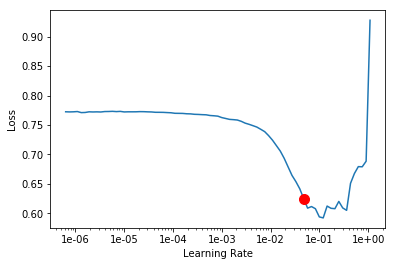

In [19]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [20]:
learn.fit(10,lr=1e-2)
#learn.fit(30,lr=3e-3)

epoch,train_loss,valid_loss,accuracy,AUROC,time
0,0.091725,2.730498,0.972692,0.893663,15:59
1,0.086451,104.117195,0.969271,0.901443,22:55
2,0.093947,0.091146,0.974306,0.904056,22:56
3,0.084594,0.085028,0.975740,0.917036,23:01
4,0.090568,0.087626,0.975378,0.907255,22:52
5,0.085159,1.963926,0.976293,0.906993,22:59
6,0.085381,0.259366,0.974487,0.911527,22:53
7,0.093754,0.085678,0.974882,0.914174,22:50
8,0.083339,0.085358,0.975864,0.914642,22:52


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.98E-03


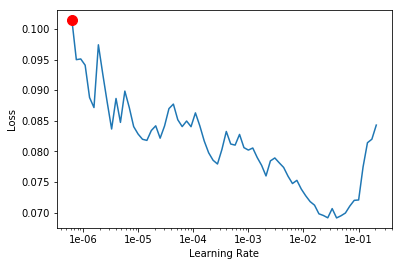

In [21]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [22]:
learn.unfreeze()
#learn.fit_one_cycle(10,max_lr=1e-6)
learn.fit_one_cycle(10,max_lr=5e-5)

epoch,train_loss,valid_loss,accuracy,AUROC,time
0,0.073249,0.082556,0.976677,0.920968,14:13
1,0.077132,0.186450,0.975830,0.922667,23:21
2,0.070138,0.218278,0.975841,0.925262,24:19
3,0.076709,0.079538,0.977851,0.928550,24:28
4,0.068315,0.090638,0.976948,0.929126,24:28
5,0.068094,0.077849,0.977986,0.931046,23:58
6,0.074735,0.075954,0.978359,0.932042,23:12
7,0.069414,0.078649,0.978122,0.931885,22:34
8,0.070915,0.075608,0.978551,0.932504,21:45


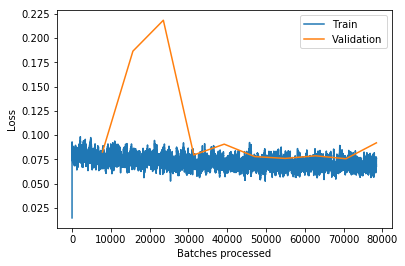

In [23]:
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Failed to compute the gradients, there might not be enough points.


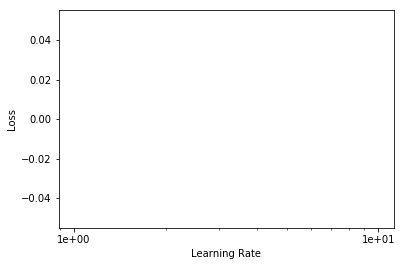

In [24]:
#learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [25]:
learn.unfreeze()
#learn.fit_one_cycle(10,max_lr=1e-6)
learn.fit_one_cycle(1,max_lr=1e-8)

epoch,train_loss,valid_loss,accuracy,AUROC,time


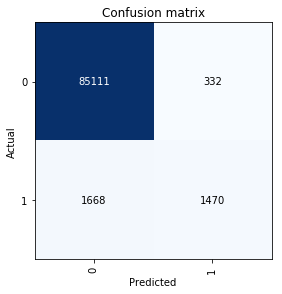

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [27]:
test_pred = learn.get_preds(DatasetType.Test)

In [28]:
sample_submission.isFraud = test_pred[0][:,1].numpy()
sample_submission.head()

,isFraud
TransactionID,
3663549,0.000398
3663550,0.001331
3663551,0.001910
3663552,0.000338
3663553,0.004647


In [29]:
sample_submission.to_csv('simple_fastai_v3.csv')